<a href="https://colab.research.google.com/github/jajapuramshivasai/Portfolio_Optimization_QAOA/blob/main/portfolio_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pennylane
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 35.5 MB/s eta 0:00:00


# Portfolio Optimization Model

This notebook describes a portfolio optimization model with binary variables, linear constraints, and a quadratic objective.

---

## 1. Input Parameters

- **Securities $C$:**
  - $p_c$: Market price
  - $m_c$: Minimum trade
  - $M_c$: Maximum trade
  - $i_c$: Basket inventory
  - $\delta_c$: Minimum increment

- **Risk Buckets $L$:**
  - $K_\ell$: Bonds in bucket $\ell$ (not mutually exclusive)

- **Characteristics $J$:**
  - $K^{\text{target}}_{\ell, j}$: Target of characteristic $j$ in risk bucket $\ell$
  - $b^{\text{up}}_{\ell, j}$, $b^{\text{low}}_{\ell, j}$: Guardrails for characteristic $j$ in risk bucket $\ell$
  - $\beta_{c, j}$: Contribution of a unit of bond $c$ to the target of characteristic $j$
  - $K^{\text{up}}_{\ell, j}$, $K^{\text{low}}_{\ell, j}$: Guardrails for characteristic $j$ in risk bucket $\ell$ (binary version)

- **Global Parameters:**
  - $N$: Maximum number of bonds in portfolio
  - Minimum/maximum residual cash flow of portfolio

---

## 2. Decision Variables

- $y_c$: Binary variable indicating whether bond $c$ is included in the portfolio

> **Note:** The variable $x_c$ (how much of bond $c$ is included in the basket) is not a decision variable, but is fixed to the average value it is allowed to have if $c$ is included at all in the portfolio:
>
> $$x_c = \frac{m_c + \min(M_c, i_c)}{2 \delta_c} y_c$$

---

## 3. Constraints

- **Maximum Number of Bonds:**
  $$\sum_{c \in C} y_c \leq N$$

- **Residual Cash Flow:**
  $$\frac{\max RC}{MV^b} \leq \sum_{c \in C} \frac{p_c \delta_c x_c}{100 MV^b} \leq \frac{\min RC}{MV^b}$$

- **Min/Max Value of Each Characteristic $j$ in Each Risk Group $\ell$:**
  $$\sum_{c \in K_\ell} \frac{p_c \beta_{c, j} x_c}{100 MV^b} \leq b^{\text{up}}_{\ell, j}$$
  
  $$\sum_{c \in K_\ell} \frac{p_c \beta_{c, j} x_c}{100 MV^b} \geq b^{\text{low}}_{\ell, j}$$

- **Similar Constraints on the Binary Variable $y_c$:**
  $$\sum_{c \in K_\ell} \beta_{c, j} y_c \leq K^{\text{up}}_{\ell, j}, \quad \forall j \in J, \ell \in L$$
  
  $$\sum_{c \in K_\ell} \beta_{c, j} y_c \geq K^{\text{low}}_{\ell, j}, \quad \forall j \in J, \ell \in L$$

> *Constraints that guarantee consistency between $x_c$ and $y_c$ are not needed, since $x_c$ is not a variable in this model.*

---

## 4. Objective Function

Match the value of each characteristic $j$ in each risk group $\ell$ to its target (based on the quantity $x_c$ in the basket):

$$\min \sum_{\ell \in L} \sum_{j \in J} \rho_j \left( \sum_{c \in K_\ell} \beta_{c, j} x_c - K^{\text{target}}_{\ell, j} \right)^2$$

---

## 5. Summary Table

| Symbol | Description |
|--------|-------------|
| $p_c$ | Market price of bond $c$ |
| $m_c$ | Minimum trade of bond $c$ |
| $M_c$ | Maximum trade of bond $c$ |
| $i_c$ | Basket inventory of bond $c$ |
| $\delta_c$ | Minimum increment for bond $c$ |
| $y_c$ | Binary: is bond $c$ in the portfolio |
| $x_c$ | Quantity of bond $c$ (fixed if included) |
| $K_\ell$ | Bonds in risk bucket $\ell$ |
| $K^{\text{target}}_{\ell, j}$ | Target of characteristic $j$ in bucket $\ell$ |
| $b^{\text{up}}_{\ell, j}$, $b^{\text{low}}_{\ell, j}$ | Guardrails for characteristic $j$ in bucket $\ell$ |
| $\beta_{c, j}$ | Contribution of bond $c$ to characteristic $j$ |
| $K^{\text{up}}_{\ell, j}$, $K^{\text{low}}_{\ell, j}$ | Binary guardrails for characteristic $j$ in bucket $\ell$ |
| $N$ | Max number of bonds in portfolio |
| $MV^b$ | Market value of the basket |
| $\rho_j$ | Weight for characteristic $j$ in objective |
| $RC$ | Residual cash flow |

---




# Data loading and processing

In [2]:
import pandas as pd
import numpy as np
import logging

def load_vanguard_data():
    data_file = "data_assets_dump_partial.xlsx"
    try:
        excel_file = pd.ExcelFile(data_file)
        print("Available sheets:", excel_file.sheet_names)
        df = pd.read_excel(data_file, sheet_name=0)
        print(f"\nDataset shape: {df.shape}")
        print(f"Columns: {list(df.columns)}")
        print(f"\nFirst few rows:")
        print(df.head())
        print(f"\nData types:")
        print(df.dtypes)
        print(f"\nMissing values:")
        print(df.isnull().sum())
        return df
    except Exception as e:
        logging.error(f"Error loading data: {e}")
        raise

def analyze_data_structure(df):
    key_columns = {
        'asset_id': ['assetId', 'asset_id', 'id', 'cusip', 'isin'],
        'price': ['price', 'market_price', 'clean_price', 'dirty_price'],
        'quantity': ['quantity', 'position', 'holdings', 'notional'],
        'benchmark_weight': ['benchmark', 'bench', 'target_weight', 'index_weight'],
        'duration': ['duration', 'oad', 'modified_duration', 'eff_duration'],
        'credit_rating': ['rating', 'credit', 'quality', 'grade'],
        'sector': ['sector', 'industry', 'gics', 'classification']
    }
    found_columns = {}
    for category, possible_names in key_columns.items():
        found = []
        for col in df.columns:
            for possible in possible_names:
                if possible.lower() in col.lower():
                    found.append(col)
        found_columns[category] = list(set(found))
    print("\nIdentified key columns:")
    for category, columns in found_columns.items():
        print(f"  {category}: {columns}")
    return found_columns

def prepare_qubo_data(df, found_columns):
    df_clean = df.copy()
    critical_columns = []
    for category in ['asset_id', 'price']:
        if found_columns[category]:
            critical_columns.extend(found_columns[category][:1])
    if critical_columns:
        df_clean = df_clean.dropna(subset=critical_columns)
        print(f"After removing missing critical data: {len(df_clean)} securities")
    column_mapping = {}
    if found_columns['asset_id']:
        column_mapping[found_columns['asset_id'][0]] = 'asset_id'
    if found_columns['price']:
        column_mapping[found_columns['price'][0]] = 'price'
    if found_columns['quantity']:
        column_mapping[found_columns['quantity'][0]] = 'current_position'
    if found_columns['benchmark_weight']:
        column_mapping[found_columns['benchmark_weight'][0]] = 'benchmark_weight'
    if found_columns['duration']:
        column_mapping[found_columns['duration'][0]] = 'duration'
    df_clean = df_clean.rename(columns=column_mapping)
    print(f"Column mapping applied: {column_mapping}")
    print(f"Final dataset shape: {df_clean.shape}")
    return df_clean

In [17]:
df = load_vanguard_data()
print("_"*50)
found_columns = analyze_data_structure(df)
print("_"*50)
df_clean = prepare_qubo_data(df, found_columns).head(10)                                 #Select num data points


Available sheets: ['Sheet1']

Dataset shape: (2629, 278)
Columns: ['Unnamed: 0', 'isin', 'ccy', 'assetId', 'strategyName', 'secGroup', 'secType', 'cpn', 'posSource', 'baseCcy', 'krd10y', 'krd15y', 'krd20y', 'krd25y', 'krd30y', 'krd1y', 'krd2y', 'krd3m', 'krd3y', 'krd40y', 'krd50y', 'krd5y', 'krd7y', 'oad', 'oas', 'spreadDur', 'issuerCountry', 'countryRisk', 'issuerId', 'issuerLongName', 'issuerShortName', 'issuerTicker', 'portfolioName', 'fund_posQuantity', 'maturity', 'minTradeIncrement', 'minTradeSize', 'fund_orderStatus', 'fund_enriched.mktValue', 'fund_enriched.notionalMktValue', 'enriched.cashladder_tCashBalance', 'enriched.cashladder_tPlus1CashBalance', 'enriched.cashladder_tPlus2CashBalance', 'enriched.cashladder_tPlus3CashBalance', 'enriched.cashladder_tPlus4CashBalance', 'enriched.cashladder_tPlus5CashBalance', 'enriched.cashladder_tPlus6CashBalance', 'enriched.cashladder_tPlus7CashBalance', 'enriched.cashladder_tPlus30CashBalance', 'enriched.cashladder_tPlus60CashBalance', 'e

# QUBO formulation

In [18]:
def create_objective_matrix(df, penalty_weights, max_assets):
    n_assets = len(df)
    Q = np.zeros((n_assets, n_assets))
    linear_terms = np.zeros(n_assets)
    if 'benchmark_weight' in df.columns:
        benchmark_weights = df['benchmark_weight'].fillna(0).values
        if benchmark_weights.sum() > 0:
            benchmark_weights = benchmark_weights / benchmark_weights.sum()
        for i in range(n_assets):
            linear_terms[i] += penalty_weights['tracking_error'] * (-2 * benchmark_weights[i])
            Q[i, i] += penalty_weights['tracking_error']
    concentration_penalty = 10.0
    for i in range(n_assets):
        for j in range(n_assets):
            if i != j:
                Q[i, j] += concentration_penalty
    budget_target = max_assets
    for i in range(n_assets):
        linear_terms[i] += penalty_weights['budget'] * (-2 * budget_target)
        for j in range(n_assets):
            Q[i, j] += penalty_weights['budget']
    return Q, linear_terms

def add_risk_constraints(Q, linear_terms, df, penalty_weights, max_assets):
    n_assets = len(df)
    if 'duration' in df.columns:
        durations = df['duration'].fillna(0).values
        target_duration = np.mean(durations[durations > 0])
        if target_duration > 0:
            duration_penalty = penalty_weights['risk_limits'] * 0.1
            for i in range(n_assets):
                duration_dev_i = durations[i] - target_duration
                for j in range(n_assets):
                    duration_dev_j = durations[j] - target_duration
                    Q[i, j] += duration_penalty * duration_dev_i * duration_dev_j
    if 'sector' in df.columns:
        sectors = df['sector'].fillna('Other')
        unique_sectors = sectors.unique()
        sector_limit = 0.3
        max_assets_per_sector = int(max_assets * sector_limit)
        sector_penalty = penalty_weights['risk_limits'] * 0.2
        for sector in unique_sectors:
            sector_assets = df[df['sector'] == sector].index.tolist()
            if len(sector_assets) > max_assets_per_sector:
                for i in sector_assets:
                    linear_terms[i] += sector_penalty * (-2 * max_assets_per_sector)
                    for j in sector_assets:
                        Q[i, j] += sector_penalty
    if 'credit_rating' in df.columns:
        ratings = df['credit_rating'].fillna('NR')
        high_risk_ratings = ['BB', 'B', 'CCC', 'CC', 'C', 'D']
        high_risk_mask = ratings.isin(high_risk_ratings)
        if high_risk_mask.sum() > 0:
            high_risk_penalty = penalty_weights['risk_limits'] * 0.3
            high_risk_indices = df[high_risk_mask].index.tolist()
            max_high_risk = int(max_assets * 0.1)
            for i in high_risk_indices:
                linear_terms[i] += high_risk_penalty * (-2 * max_high_risk)
                for j in high_risk_indices:
                    Q[i, j] += high_risk_penalty
    return Q, linear_terms

def add_practical_constraints(Q, linear_terms, df, penalty_weights, max_assets):
    n_assets = len(df)
    if 'price' in df.columns:
        prices = df['price'].fillna(100).values
        min_position_value = 1000000
        small_position_penalty = penalty_weights['turnover']
        for i in range(n_assets):
            if prices[i] > 0:
                if prices[i] * 1000 < min_position_value:
                    linear_terms[i] += small_position_penalty * 0.1
    missing_price_penalty = penalty_weights['turnover'] * 0.5
    for i in range(n_assets):
        if 'price' in df.columns:
            if pd.isna(df.iloc[i]['price']) or df.iloc[i]['price'] <= 0:
                linear_terms[i] += missing_price_penalty
    return Q, linear_terms

def formulate_complete_qubo(df):
    n_assets = len(df)
    penalty_weights = {
        'tracking_error': 1000.0,
        'risk_limits': 500.0,
        'budget': 2000.0,
        'turnover': 100.0
    }
    max_assets = min(30, n_assets // 2)
    Q, linear_terms = create_objective_matrix(df, penalty_weights, max_assets)
    Q, linear_terms = add_risk_constraints(Q, linear_terms, df, penalty_weights, max_assets)
    Q, linear_terms = add_practical_constraints(Q, linear_terms, df, penalty_weights, max_assets)
    Q = (Q + Q.T) / 2
    return Q, linear_terms, max_assets

In [19]:
Q, linear_terms, max_assets = formulate_complete_qubo(df_clean)


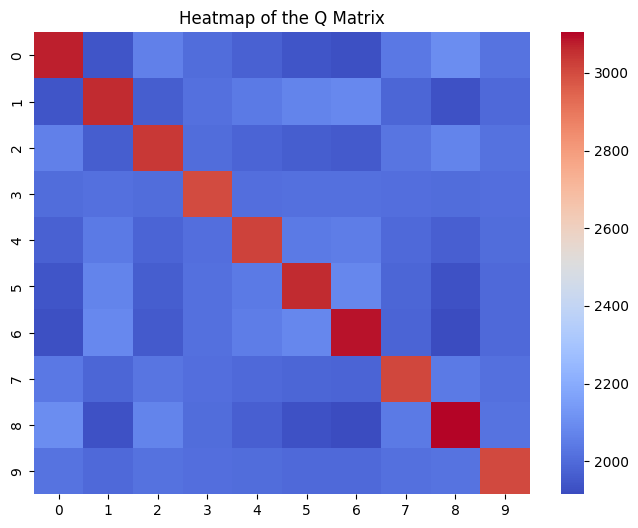

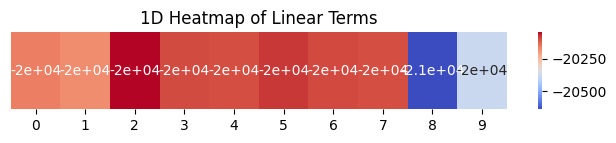

Maximum number of assets to select (max_assets): 5


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(8, 6))
sns.heatmap(Q, cmap='coolwarm', annot=False)
plt.title('Heatmap of the Q Matrix')

plt.show()

plt.figure(figsize=(8, 1))
sns.heatmap(linear_terms.reshape(1, -1), cmap='coolwarm', annot=True, cbar=True)
plt.title('1D Heatmap of Linear Terms')

plt.yticks([])
plt.show()


# Printing the max_assets value
print(f"Maximum number of assets to select (max_assets): {max_assets}")

# Solving QUBO problem using QAOA

In [21]:
import numpy as np
import pandas as pd
import pennylane as qml
from pennylane import numpy as pnp
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def qubo_to_pennylane_hamiltonian(Q):

    n = Q.shape[0]

    # Create Hamiltonian terms
    coeffs = []
    ops = []

    # Linear terms (diagonal elements)
    for i in range(n):
        if Q[i, i] != 0:
            coeffs.append(Q[i, i])
            ops.append(qml.PauliZ(i))

    # Quadratic terms (off-diagonal elements)
    for i in range(n):
        for j in range(i + 1, n):
            if Q[i, j] != 0:
                coeffs.append(Q[i, j])
                ops.append(qml.PauliZ(i) @ qml.PauliZ(j))

    # Create Hamiltonian
    if coeffs:
        H = qml.Hamiltonian(coeffs, ops)
    else:

        H = qml.Hamiltonian([0.0], [qml.Identity(0)])

    return H

class PennyLaneQAOASolver:
    def __init__(self, Q, layers=6, shots=1024, backend='default.qubit'):
        self.Q = Q
        self.n_qubits = Q.shape[0]
        self.layers = layers
        self.shots = shots

        # Create Hamiltonian
        self.cost_hamiltonian = qubo_to_pennylane_hamiltonian(Q)

        # Set up device
        self.dev = qml.device(backend, wires=self.n_qubits, shots=shots)

        print(f" QAOA Solver initialized:")
        print(f"  - Problem size: {self.n_qubits} qubits")
        print(f"  - QAOA layers: {self.layers}")
        print(f"  - Backend: {backend}")
        print(f"  - Shots: {shots}")

    def qaoa_circuit(self, params):

        gammas = params[:self.layers]
        betas = params[self.layers:]

        # equal superposition
        for i in range(self.n_qubits):
            qml.Hadamard(wires=i)

        # QAOA layers
        for layer in range(self.layers):
            # Cost layer
            qml.ApproxTimeEvolution(self.cost_hamiltonian, gammas[layer], 1)

            # Mixer layer
            for i in range(self.n_qubits):
                qml.RX(2 * betas[layer], wires=i)

    def create_cost_function(self):

        @qml.qnode(self.dev)
        def cost_circuit(params):
            self.qaoa_circuit(params)
            return qml.expval(self.cost_hamiltonian)

        return cost_circuit

    def create_sampling_function(self):
        @qml.qnode(self.dev)
        def sampling_circuit(params):
            self.qaoa_circuit(params)
            return qml.sample()

        return sampling_circuit

    def evaluate_bitstring(self, bitstring):

        x = np.array(bitstring, dtype=int)
        return x.T @ self.Q @ x

    def solve(self, maxiter=100, method='COBYLA'):


        print(f"Starting  QAOA optimization...")
        print(f"  - Optimizer: {method}")
        print(f"  - Max iterations: {maxiter}")

        # Create cost function
        cost_fn = self.create_cost_function()

        # Random initial parameters
        init_params = np.random.uniform(0, 2*np.pi, 2 * self.layers)

        # Classical optimization
        print("Running classical optimization...")
        if method == 'COBYLA':
            opt_result = minimize(cost_fn, init_params, method='COBYLA',
                                options={'maxiter': maxiter})
        else:
            opt_result = minimize(cost_fn, init_params, method=method,
                                options={'maxiter': maxiter})

        print(f"Optimization completed!")
        print(f"  - Success: {opt_result.success}")
        print(f"  - Iterations: {opt_result.nfev}")
        print(f"  - Final cost: {opt_result.fun:.4f}")

        # Get final samples
        sampling_fn = self.create_sampling_function()
        samples = sampling_fn(opt_result.x)

        # Process samples
        unique_samples, counts = np.unique(samples, axis=0, return_counts=True)

        # Find best solution
        best_objective = float('inf')
        best_solution = None

        results = []
        for sample, count in zip(unique_samples, counts):
            obj_val = self.evaluate_bitstring(sample)
            prob = count / len(samples)
            results.append({
                'bitstring': sample,
                'count': count,
                'probability': prob,
                'objective': obj_val
            })

            if obj_val < best_objective:
                best_objective = obj_val
                best_solution = sample

        # Sort results by objective value
        results.sort(key=lambda x: x['objective'])

        return {
            'solution': best_solution,
            'objective_value': best_objective,
            'optimization_result': opt_result,
            'all_results': results,
            'samples': samples
        }

    def analyze_results(self, result):
        print("="*50)


        # Plot probability distribution
        if len(result['all_results']) > 1:
            probs = [res['probability'] for res in result['all_results'][:10]]
            labels = [str(res['bitstring']) for res in result['all_results'][:10]]

            plt.figure(figsize=(12, 6))
            plt.bar(range(len(probs)), probs)
            plt.xlabel('Solution Index')
            plt.ylabel('Probability')
            plt.title('Top 10 Solution Probabilities')
            plt.xticks(range(len(labels)), labels, rotation=45)
            plt.tight_layout()
            plt.show()

def solve_portfolio_pennylane(Q, linear_terms, max_assets):

    print("=" * 50)



    # Combine linear terms into Q matrix
    Q_combined = Q.copy()
    np.fill_diagonal(Q_combined, np.diag(Q) + linear_terms)

    print(f"\nQUBO Problem Setup:")
    print(f"  - Assets available: {len(df_clean)}")
    print(f"  - Target portfolio size: {max_assets}")
    print(f"  - QUBO matrix size: {Q_combined.shape}")

    solver = PennyLaneQAOASolver(Q_combined, layers=6)
    result = solver.solve(maxiter=100, method='COBYLA')
    solver.analyze_results(result)

    selected_indices = np.where(result['solution'] == 1)[0]
    selected_portfolio = df_clean.iloc[selected_indices]

    print(f"\n" + "="*50)
    print("SELECTED PORTFOLIO ANALYSIS")
    print("="*50)

    print(f"Selected {len(selected_indices)} assets:")
    for i, (idx, row) in enumerate(selected_portfolio.iterrows()):
        asset_id = row.get('asset_id', f'Asset_{idx}')
        price = row.get('price', 'N/A')
        print(f"  {i+1}. {asset_id} | Price: ${price}")

    if 'price' in selected_portfolio.columns:
        total_value = selected_portfolio['price'].sum()
        print(f"\nTotal portfolio value: ${total_value:,.0f}")

    if 'sector' in selected_portfolio.columns:
        print(f"\nSector distribution:")
        sector_counts = selected_portfolio['sector'].value_counts()
        for sector, count in sector_counts.items():
            print(f"  {sector}: {count} assets")

    return result, selected_portfolio, solver


def solve_with_builtin_qaoa(Q, layers=6):


    n_qubits = Q.shape[0]
    dev = qml.device('default.qubit', wires=n_qubits)

    # Convert QUBO to cost Hamiltonian
    cost_h = qubo_to_pennylane_hamiltonian(Q)

    # Mixer Hamiltonian (sum of X operators)
    mixer_h = qml.qaoa.x_mixer(range(n_qubits))

    # QAOA cost function
    def qaoa_layer(gamma, beta):
        qml.qaoa.cost_layer(gamma, cost_h)
        qml.qaoa.mixer_layer(beta, mixer_h)

    @qml.qnode(dev)
    def circuit(params):
        # Initial state
        for i in range(n_qubits):
            qml.Hadamard(wires=i)

        # QAOA layers
        for i in range(layers):
            qaoa_layer(params[i], params[i + layers])

        return qml.expval(cost_h)

    # Optimize
    init_params = np.random.uniform(0, 2*np.pi, 2 * layers)
    opt_result = minimize(circuit, init_params, method='COBYLA')
    print(qml.draw_mpl(circuit,style='black_white_dark')(opt_result.x))

    # print(f"Built-in QAOA result: {opt_result.fun:.4f}")

    # return opt_result





(<Figure size 1600x1100 with 1 Axes>, <Axes: >)


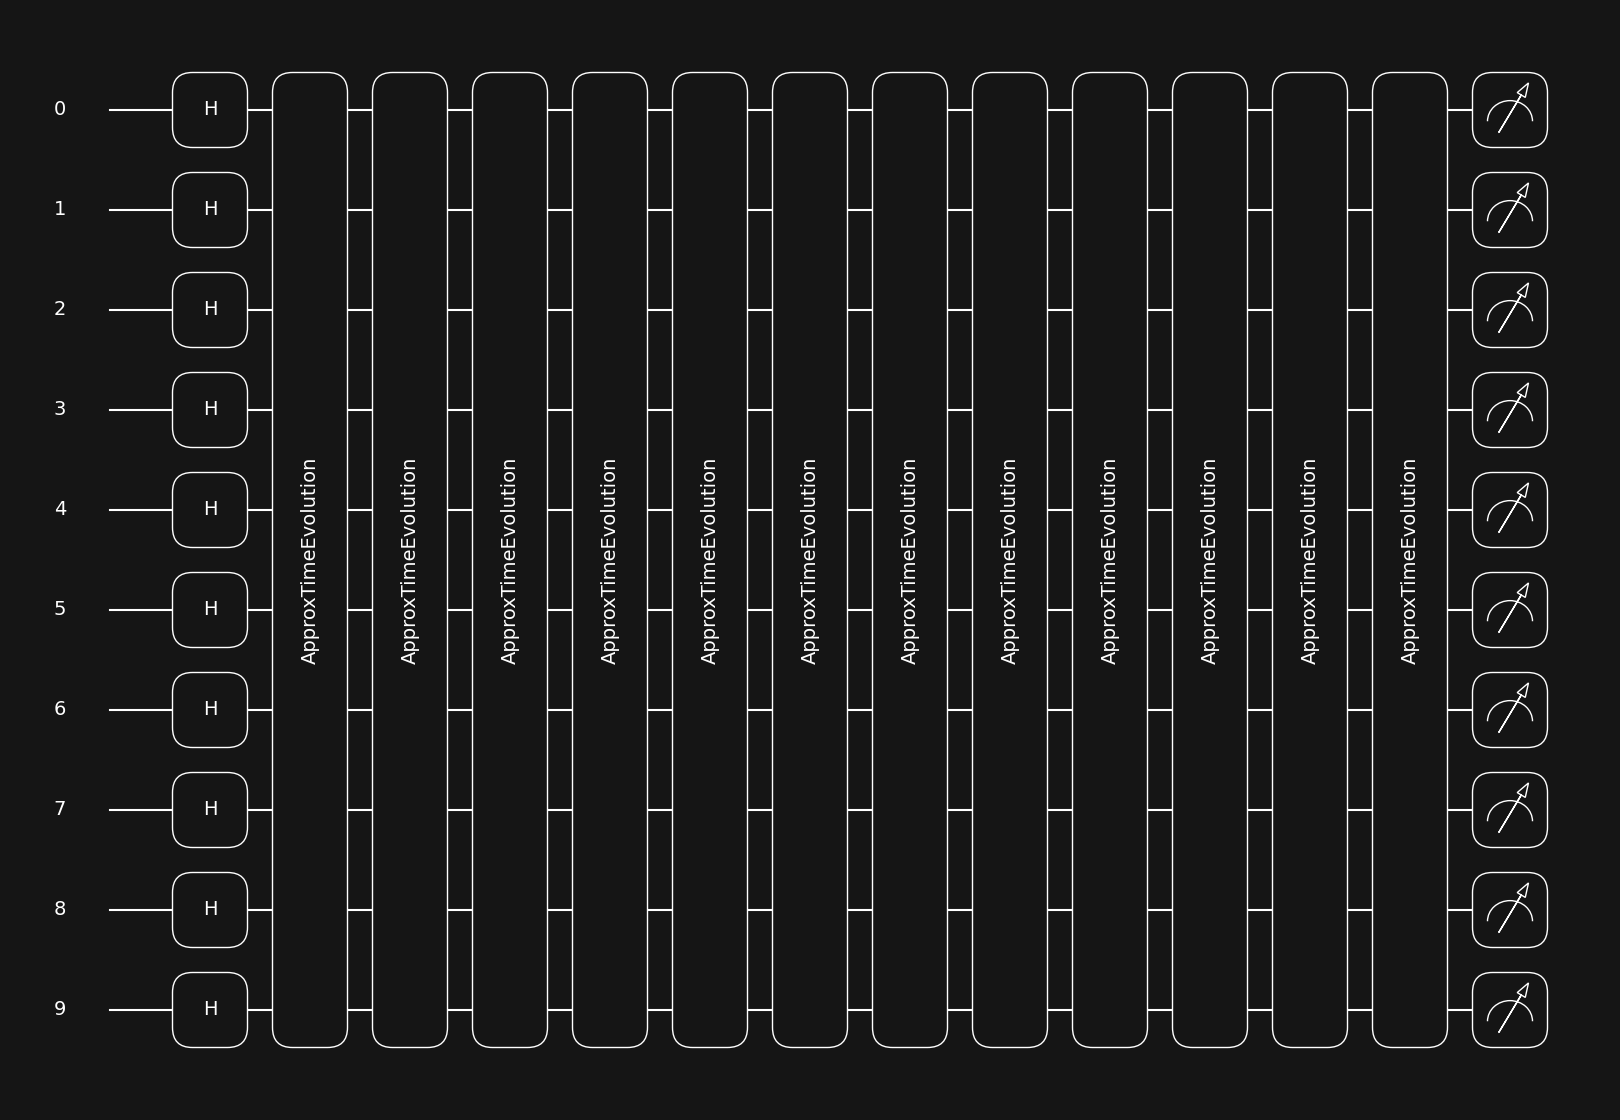

In [22]:
solve_with_builtin_qaoa(Q,6)


QUBO Problem Setup:
  - Assets available: 10
  - Target portfolio size: 5
  - QUBO matrix size: (10, 10)
 QAOA Solver initialized:
  - Problem size: 10 qubits
  - QAOA layers: 6
  - Backend: default.qubit
  - Shots: 1024
Starting  QAOA optimization...
  - Optimizer: COBYLA
  - Max iterations: 100
Running classical optimization...
Optimization completed!
  - Success: True
  - Iterations: 94
  - Final cost: -7689.7824


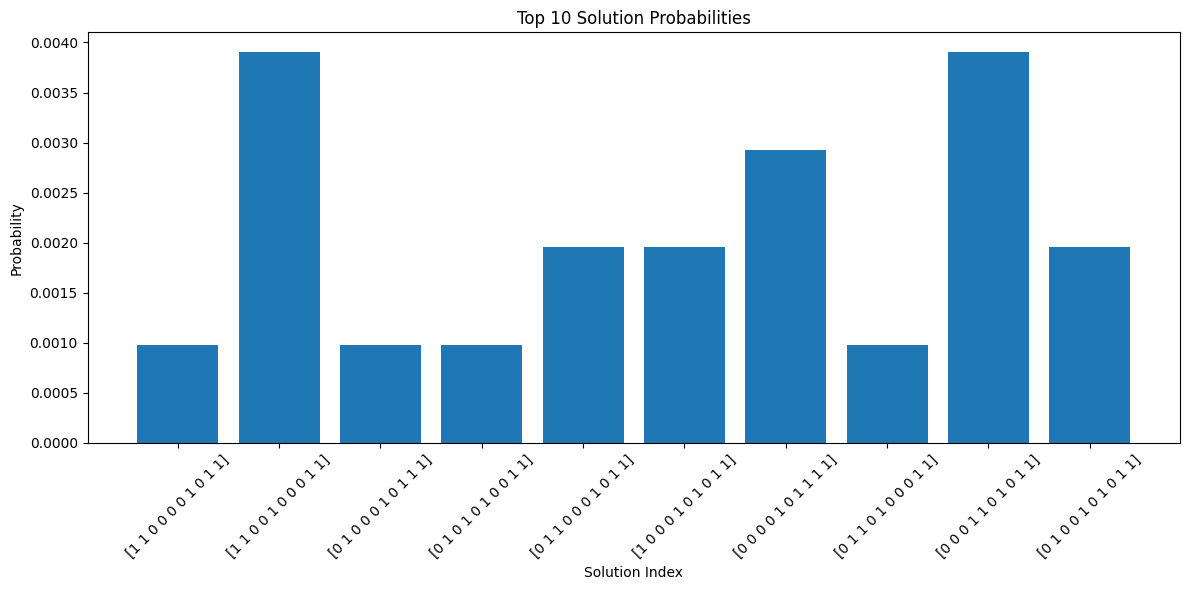


SELECTED PORTFOLIO ANALYSIS
Selected 5 assets:
  1. 001055BJ0 | Price: $95.119361
  2. 001084AS1 | Price: $102.6726676666667
  3. 00115AAR0 | Price: $101.3758677777778
  4. 00206RGQ9 | Price: $98.61198266666668
  5. 00206RJY9 | Price: $89.3874201111111

Total portfolio value: $487


In [23]:
portfolio_result, portfolio, solver = solve_portfolio_pennylane(Q, linear_terms, max_assets)

# Classical solution


In [24]:

def solve_classical_approximation(Q, linear_terms, max_assets):
    n_assets = len(linear_terms)
    asset_scores = linear_terms.copy()
    for i in range(len(asset_scores)):
        asset_scores[i] += Q[i, i]
    sorted_indices = np.argsort(asset_scores)
    selected_assets = sorted_indices[:max_assets]
    solution_greedy = np.zeros(n_assets, dtype=int)
    solution_greedy[selected_assets] = 1
    obj_value_greedy = (
        np.dot(solution_greedy, linear_terms) +
        np.dot(solution_greedy, np.dot(Q, solution_greedy))
    )
    best_solution = None
    best_objective = float('inf')
    n_samples = 1000
    for _ in range(n_samples):
        random_indices = np.random.choice(n_assets, max_assets, replace=False)
        solution = np.zeros(n_assets, dtype=int)
        solution[random_indices] = 1
        obj_value = (
            np.dot(solution, linear_terms) +
            np.dot(solution, np.dot(Q, solution))
        )
        if obj_value < best_objective:
            best_objective = obj_value
            best_solution = solution.copy()
    if best_objective < obj_value_greedy:
        return best_solution, best_objective, "random_sampling"
    else:
        return solution_greedy, obj_value_greedy, "greedy"

def analyze_solution(solution, df):
    selected_indices = np.where(solution == 1)[0]
    selected_df = df.iloc[selected_indices].copy()
    print(f"\nSelected {len(selected_indices)} assets:")
    # Additional summary stats as desired...
    return selected_df

def solve_classic(Q, linear_terms, max_assets):
    solution, obj_value, method = solve_classical_approximation(Q, linear_terms, max_assets)
    selected_portfolio = analyze_solution(solution, df_clean)
    print(f"\nSOLUTION FOUND using {method}")
    print(f"Objective value: {obj_value:.2f}")
    return Q, linear_terms, solution



In [25]:
Q, linear_terms, solution= solve_classic(Q, linear_terms, max_assets)
print(solution)


Selected 5 assets:

SOLUTION FOUND using random_sampling
Objective value: -46246.41
[1 1 0 0 0 0 1 0 1 1]


# Comparision , Verification and result


In [26]:
print("\n" + "="*50)
print("COMPARISON OF CLASSICAL AND QAOA RESULTS")
print("="*50)

classical_solution = solution
classical_objective = (
    np.dot(classical_solution, linear_terms) +
    np.dot(classical_solution, np.dot(Q, classical_solution))
)
classical_selected_indices = np.where(classical_solution == 1)[0]
classical_portfolio_df = df_clean.iloc[classical_selected_indices]


qaoa_solution = portfolio_result['solution']
qaoa_objective = portfolio_result['objective_value']
qaoa_selected_indices = np.where(qaoa_solution == 1)[0]
qaoa_portfolio_df = df_clean.iloc[qaoa_selected_indices]


# Compare Objective Values
print(f"\nBest Objective Value (Classical Approximation): {classical_objective:.4f}")
print(f"Best Objective Value (PennyLane QAOA):          {qaoa_objective:.4f}")

# Compare Selected Assets
print("\nSelected Assets (Classical Approximation):")
if not classical_portfolio_df.empty:
    for i, (idx, row) in enumerate(classical_portfolio_df.iterrows()):
        asset_id = row.get('asset_id', f'Asset_{idx}')
        print(f"  {i+1}. {asset_id}")
else:
    print("  No assets selected.")

print("\nSelected Assets (PennyLane QAOA):")
if not qaoa_portfolio_df.empty:
    for i, (idx, row) in enumerate(qaoa_portfolio_df.iterrows()):
        asset_id = row.get('asset_id', f'Asset_{idx}')
        print(f"  {i+1}. {asset_id}")
else:
    print("  No assets selected.")
      # Overlap and Differences
classical_asset_ids = set(classical_portfolio_df.get('asset_id', classical_portfolio_df.index).tolist())
qaoa_asset_ids = set(qaoa_portfolio_df.get('asset_id', qaoa_portfolio_df.index).tolist())

overlap_assets = classical_asset_ids.intersection(qaoa_asset_ids)
classical_only = classical_asset_ids - qaoa_asset_ids
qaoa_only = qaoa_asset_ids - classical_asset_ids

print(f"\nNumber of selected assets:")
print(f"  Classical: {len(classical_asset_ids)}")
print(f"  QAOA:      {len(qaoa_asset_ids)}")

print(f"\nOverlap in selected assets: {len(overlap_assets)}")
if overlap_assets:
    print(f"  Assets in both: {list(overlap_assets)}")

print(f"Assets selected only by Classical: {len(classical_only)}")
if classical_only:
     print(f"  Classical only: {list(classical_only)}")

print(f"Assets selected only by QAOA: {len(qaoa_only)}")
if qaoa_only:
    print(f"  QAOA only: {list(qaoa_only)}")



COMPARISON OF CLASSICAL AND QAOA RESULTS

Best Objective Value (Classical Approximation): -46246.4062
Best Objective Value (PennyLane QAOA):          -46246.4062

Selected Assets (Classical Approximation):
  1. 001055BJ0
  2. 001084AS1
  3. 00115AAR0
  4. 00206RGQ9
  5. 00206RJY9

Selected Assets (PennyLane QAOA):
  1. 001055BJ0
  2. 001084AS1
  3. 00115AAR0
  4. 00206RGQ9
  5. 00206RJY9

Number of selected assets:
  Classical: 5
  QAOA:      5

Overlap in selected assets: 5
  Assets in both: ['00206RJY9', '001055BJ0', '00115AAR0', '001084AS1', '00206RGQ9']
Assets selected only by Classical: 0
Assets selected only by QAOA: 0


## Summary:



*   Plotting of the top 10 QAOA results (probabilities and objective values) and comparing with classical solutions shows that QAOA is accuratly predicting the solution.

*   For the specific problem instance and parameters used, the classical approximation and the PennyLane QAOA solver yielded the same best objective value and selected the same set of assets.

*   The ability of QAOA to explore depends on number of layers and tailorig circuit to symmetry in possible solutions for efficient subspace.

